Use training set only.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (f1_score, roc_auc_score, accuracy_score,
                             precision_score, recall_score, precision_recall_curve,
                             roc_curve, confusion_matrix)
from sklearn.preprocessing import StandardScaler, label_binarize, normalize
from sklearn.pipeline import Pipeline, FeatureUnion

from pymongo import MongoClient
from functions.model import compute_multiclass_roc, TextSelector, NumberSelector
from functions.plotting import plot_empty, plot_heatmap

# Mongodb params
client = MongoClient()
medical_notes_kaggle_db = client.medical_notes_kaggle

pd.set_option('max_rows', 10)

In [2]:
save=False

# Import Data

In [3]:
# Get all Data
query = {}
results = medical_notes_kaggle_db.train.find(query)
training_set = list(results)

In [4]:
# Store headers and text data in a dataframe
train_df = pd.DataFrame(columns=['index_', 'note_text', 'section_headers', 'clinical_domain'])

to_exclude = {'_id', 'index_', 'clinical_domain'}
for note in training_set:
    train_df = train_df.append(
        [{'index_': note.get('index_'),
          'clinical_domain': note.get('clinical_domain'),
          'section_headers': ', '.join([key for key in note.keys() if key not in to_exclude]),
          'note_text': ', '.join([val for val in note.values()
                                 if val not in map(lambda key: note[key], to_exclude)])}]
    )
    
train_df['num_char'] = train_df.note_text.apply(len) # Add num_char column
train_df['num_section_headers'] = train_df['section_headers'].apply(lambda x: x.count(',') +1) # Count section headers
train_df = train_df.dropna().sort_values('index_').reset_index(drop=True)

train_df.head() # View data

,index_,note_text,section_headers,clinical_domain,num_char,num_section_headers
0,1001,"Difficulty with word finding., This 27y/o RHF ...","CC, HX, MEDS, PMH, FHX, SHX, EXAM, COURSE",Neurology,5417,8
1,1002,"Ganglion of the left wrist., Ganglion of the l...","PREOPERATIVE DIAGNOSIS, POSTOPERATIVE DIAGNOSI...",Orthopedic,1453,5
2,1003,"Cervical myelopathy, C3-4, secondary to stenos...","PREOPERATIVE DIAGNOSIS, POSTOPERATIVE DIAGNOSE...",Orthopedic,6526,13
3,1004,"MRI LEFT SHOULDER, This is a 69-year-old male ...","EXAM, CLINICAL, FINDINGS, IMPRESSION",Radiology,2757,4
4,1005,The patient is a 57-year-old female being seen...,"HISTORY OF PRESENT ILLNESS, PAST MEDICAL HISTO...",Orthopedic,3107,8


# One-Hot Encoding

In [5]:
# Apply one-hot-encoding to each of the categories
section_headers_df = pd.get_dummies(train_df.section_headers.apply(lambda x: x.split(',')).apply(pd.Series).stack()).sum(level=0)
train_df = train_df.merge(section_headers_df, left_index=True, right_index=True)
train_df.head()

,index_,note_text,section_headers,clinical_domain,num_char,num_section_headers,,1. RIGHT BICEPS,10. ANTERIOR TIBIALIS,11. RIGHT GASTROCNEMIUS,...,REPORT,RICE,RIGHT,RIGHT LOWER EXTREMITY,SUBJECTIVE,TECHNIQUE,TESTICULAR ULTRASOUND,TIME SEEN,TITLE OF OPERATION,TITLE OF PROCEDURE
0,1001,"Difficulty with word finding., This 27y/o RHF ...","CC, HX, MEDS, PMH, FHX, SHX, EXAM, COURSE",Neurology,5417,8,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1002,"Ganglion of the left wrist., Ganglion of the l...","PREOPERATIVE DIAGNOSIS, POSTOPERATIVE DIAGNOSI...",Orthopedic,1453,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1003,"Cervical myelopathy, C3-4, secondary to stenos...","PREOPERATIVE DIAGNOSIS, POSTOPERATIVE DIAGNOSE...",Orthopedic,6526,13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1004,"MRI LEFT SHOULDER, This is a 69-year-old male ...","EXAM, CLINICAL, FINDINGS, IMPRESSION",Radiology,2757,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1005,The patient is a 57-year-old female being seen...,"HISTORY OF PRESENT ILLNESS, PAST MEDICAL HISTO...",Orthopedic,3107,8,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Train-Test Split

In [6]:
# Train_test_split with stratification
features_train_df, features_test_df, target_train_ser, target_test_ser = train_test_split(
    train_df.drop(columns = ['clinical_domain']), train_df['clinical_domain'],
    stratify = train_df['clinical_domain'],
    test_size=.2, random_state=42)

In [7]:
target_train_ser.value_counts()

Orthopedic          178
Radiology           150
Gastroenterology    126
Neurology           114
Urology              92
Name: clinical_domain, dtype: int64

In [8]:
target_test_ser.value_counts()

Orthopedic          45
Radiology           38
Gastroenterology    31
Neurology           29
Urology             23
Name: clinical_domain, dtype: int64

# Logistic Regresssion on Text Only

In [9]:
# Specify order of classes
clinical_domain_list = ['Orthopedic', 'Gastroenterology', 'Urology', 'Radiology', 'Neurology', ]
count_vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,3)) #ngram_range=(1,3)
features_train_vectorized_csr = count_vectorizer.fit_transform(features_train_df['note_text']) # csr
features_test_vectorized_csr = count_vectorizer.transform(features_test_df['note_text'])

# Binarize output
target_train_bin_array = label_binarize(target_train_ser, classes=clinical_domain_list)
target_test_bin_array = label_binarize(target_test_ser, classes =clinical_domain_list)

In [10]:
# Train model
logreg_mlt_clf = LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg')
logreg_mlt_clf.fit(features_train_vectorized_csr, target_train_ser)

LogisticRegression(multi_class='multinomial', solver='newton-cg')

In [11]:
# Unweighted

features_train_vectorized_predict_array = logreg_mlt_clf.predict(features_train_vectorized_csr)
features_train_vectorized_proba_array = logreg_mlt_clf.predict_proba(features_train_vectorized_csr)
features_test_vectorized_predict_array = logreg_mlt_clf.predict(features_test_vectorized_csr)
features_test_vectorized_proba_array = logreg_mlt_clf.predict_proba(features_test_vectorized_csr)
confusion = confusion_matrix(target_test_ser, features_test_vectorized_predict_array, labels=clinical_domain_list)
confusion_normalized_array = normalize(confusion, axis=1, norm='l1')

print("Micro-Average Training Accuracy: ", f1_score(target_train_ser, features_train_vectorized_predict_array, average = "micro"))
print("Micro-Average Test Accuracy: ", f1_score(target_test_ser, features_test_vectorized_predict_array, average = "micro"))

Micro-Average Training Accuracy:  0.9181818181818182
Micro-Average Test Accuracy:  0.6927710843373494


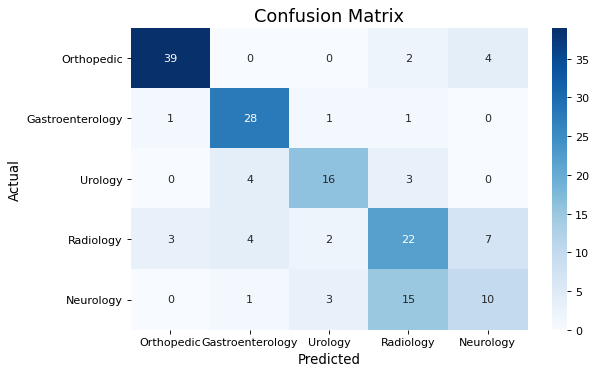

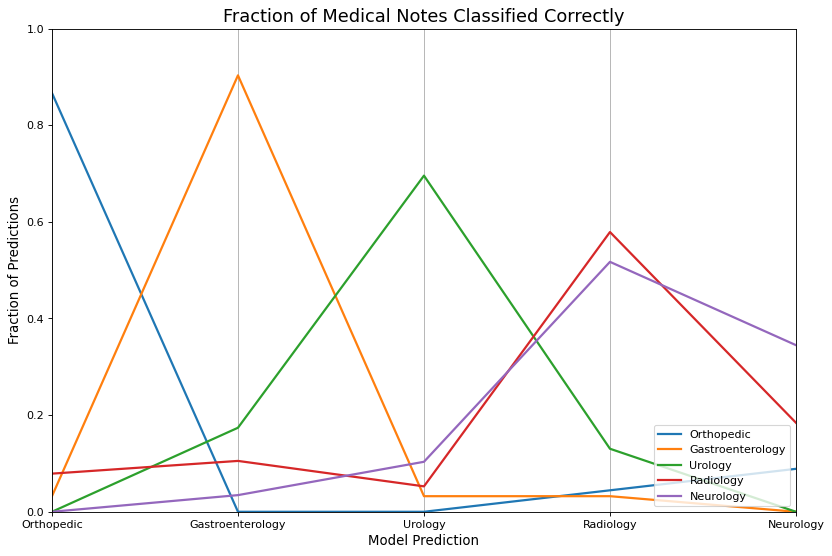

In [12]:
# Plot Multiclass Confusion Matrix
fig, ax = plot_heatmap(confusion, xlabel='Predicted', ylabel='Actual', title='Confusion Matrix',
                       xticklabels=clinical_domain_list, yticklabels=clinical_domain_list,
                       color='Blues', annot=True, fmt='d', dpi=80)
if save:
    plt.savefig("figures/logreg/section-text/confusion.png", transparent=False, bbox_inches="tight")

    
# Plot Distribution for Each Class
fig, ax = plot_empty(xlabel='Model Prediction', ylabel='Fraction of Predictions',
                     title='Fraction of Medical Notes Classified Correctly',
                     figsize=(12, 8))
for i in range(0, 5):
    ax.plot(clinical_domain_list, confusion_normalized_array[i], label=f'{clinical_domain_list[i]}', lw=2)
ax.set_xlim(0, 4)
ax.set_ylim(0, 1)
plt.legend(loc="lower right")
ax.xaxis.grid(True)
if save:
    plt.savefig("figures/logreg/section-text/fraction-classified-correctly.png", transparent=False, bbox_inches="tight")

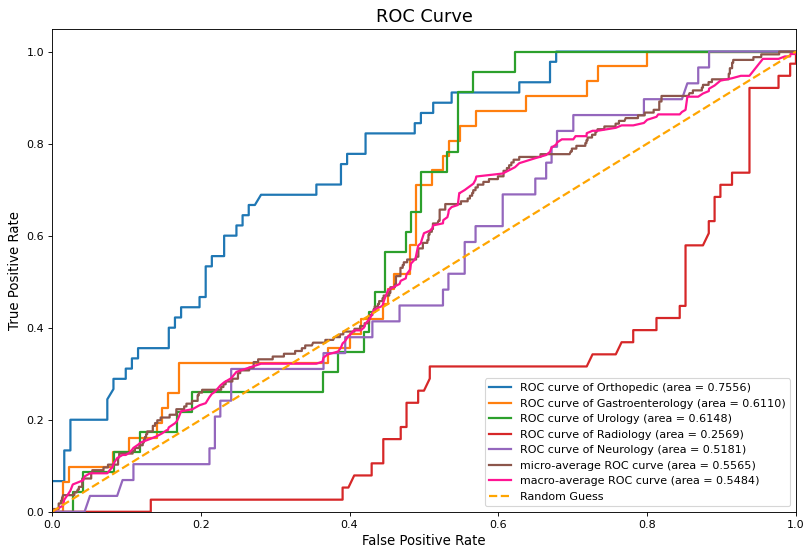

In [13]:
# Compute Multiclass ROC

fpr, tpr, thresholds, roc_auc = compute_multiclass_roc(target_test_bin_array, features_test_vectorized_proba_array)

# Plot Micro-ROC curve for Weighted Test set
fig, ax = plot_empty(xlabel='False Positive Rate', ylabel='True Positive Rate', title='ROC Curve',
                     figsize=(12, 8))
for i in range(5):
    plt.plot(1-fpr[i], 1-tpr[i], label='ROC curve of {0} (area = {1:1.4f})'.format(clinical_domain_list[i], 1-roc_auc[i]), lw=2)
plt.plot(1-fpr["micro"], 1-tpr["micro"], label='micro-average ROC curve (area = {0:0.4f})'.format(1-roc_auc["micro"]), lw=2)
plt.plot(1-fpr["macro"], 1-tpr["macro"], label='macro-average ROC curve (area = {0:0.4f})'.format(1-roc_auc["macro"]), color='deeppink', lw=2)
plt.plot([0, 1], [0, 1], c='orange', lw = 2, ls='--', label= "Random Guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
if save:
    plt.savefig("figures/logreg/section-text/roc.png", transparent=True, bbox_inches="tight")

# Logistic Regression on One-Hot Encoded Headers

In [14]:
features_train_cat_df = features_train_df.drop(columns=['index_', 'note_text', 'section_headers', 'num_char', 'num_section_headers'])
features_test_cat_df = features_test_df.drop(columns=['index_', 'note_text', 'section_headers', 'num_char', 'num_section_headers'])

# Train model
logreg_mlt_cat_clf = LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg')
logreg_mlt_cat_clf.fit(features_train_cat_df, target_train_ser)

LogisticRegression(multi_class='multinomial', solver='newton-cg')

In [15]:
# Unweighted

features_train_cat_predict_array = logreg_mlt_cat_clf.predict(features_train_cat_df)
features_train_cat_proba_array = logreg_mlt_cat_clf.predict_proba(features_train_cat_df)
features_test_cat_predict_array = logreg_mlt_cat_clf.predict(features_test_cat_df)
features_test_cat_proba_array = logreg_mlt_cat_clf.predict_proba(features_test_cat_df)
confusion = confusion_matrix(target_test_ser, features_test_cat_predict_array, labels=clinical_domain_list)
confusion_normalized_array = normalize(confusion, axis=1, norm='l1')

print("Micro-Average Training Accuracy: ", f1_score(target_train_ser, features_train_cat_predict_array, average = "micro"))
print("Micro-Average Test Accuracy: ", f1_score(target_test_ser, features_test_cat_predict_array, average = "micro"))

Micro-Average Training Accuracy:  0.7848484848484848
Micro-Average Test Accuracy:  0.4939759036144578


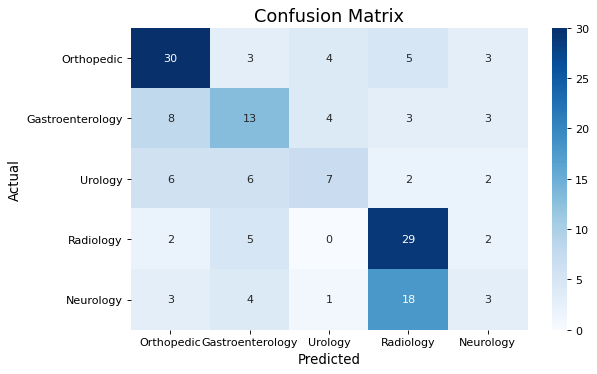

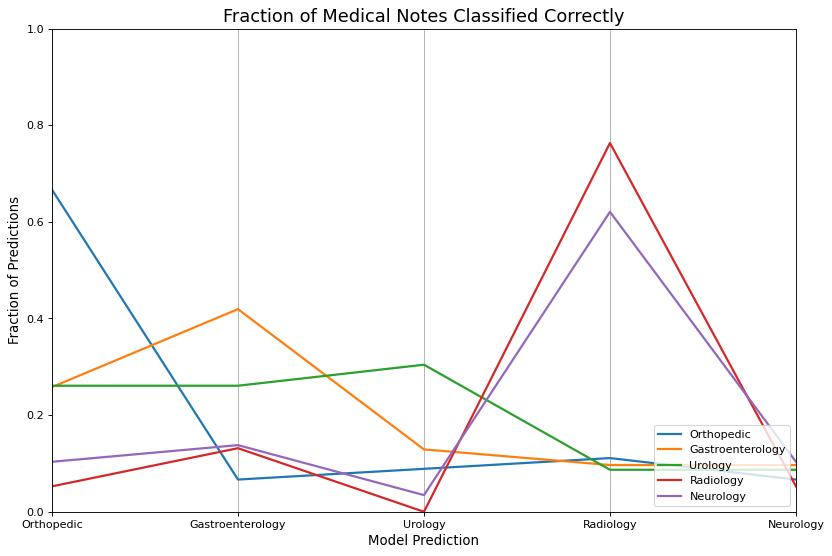

In [16]:
# Plot Multiclass Confusion Matrix
fig, ax = plot_heatmap(confusion, xlabel='Predicted', ylabel='Actual', title='Confusion Matrix',
                       xticklabels=clinical_domain_list, yticklabels=clinical_domain_list,
                       color='Blues', annot=True, fmt='d', dpi=80)
if save:
    plt.savefig("figures/logreg/headers/confusion.png", transparent=False, bbox_inches="tight")

# Plot Distribution for Each Class
fig, ax = plot_empty(xlabel='Model Prediction', ylabel='Fraction of Predictions',
                     title='Fraction of Medical Notes Classified Correctly',
                     figsize=(12, 8))
for i in range(0, 5):
    ax.plot(clinical_domain_list, confusion_normalized_array[i], label=f'{clinical_domain_list[i]}', lw=2)
ax.set_xlim(0, 4)
ax.set_ylim(0, 1)
plt.legend(loc="lower right")
ax.xaxis.grid(True)
if save:
    plt.savefig("figures/logreg/headers/fraction-classified-correctly.png", transparent=False, bbox_inches="tight")

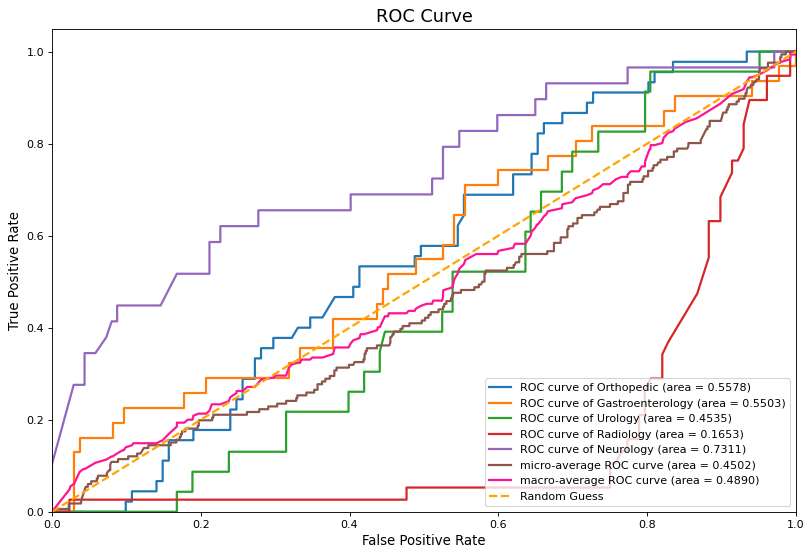

In [17]:
# Compute Multiclass ROC

fpr, tpr, thresholds, roc_auc = compute_multiclass_roc(target_test_bin_array, features_test_cat_proba_array)

# Plot Micro-ROC curve for Weighted Test set
fig, ax = plot_empty(xlabel='False Positive Rate', ylabel='True Positive Rate', title='ROC Curve',
                     figsize=(12, 8))
for i in range(5):
    plt.plot(1-fpr[i], 1-tpr[i], label='ROC curve of {0} (area = {1:1.4f})'.format(clinical_domain_list[i], 1-roc_auc[i]), lw=2)
plt.plot(1-fpr["micro"], 1-tpr["micro"], label='micro-average ROC curve (area = {0:0.4f})'.format(1-roc_auc["micro"]), lw=2)
plt.plot(1-fpr["macro"], 1-tpr["macro"], label='macro-average ROC curve (area = {0:0.4f})'.format(1-roc_auc["macro"]), color='deeppink', lw=2)
plt.plot([0, 1], [0, 1], c='orange', lw = 2, ls='--', label= "Random Guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
if save:
    plt.savefig("figures/logreg/headers/roc.png", transparent=True, bbox_inches="tight")

# Logistic Regression on All Features

Adding headers and numerical features didn't actually improve the predictions over just using text.

In [18]:
# Build the pipeline, saved for future

count = Pipeline([('selector', TextSelector(key='note_text')),
    ('count_vectorizer', CountVectorizer(stop_words='english', ngram_range=(1,3)))])
tfidf = Pipeline([('selector', TextSelector(key='note_text')),
    ('tfidf_vectorizer', TfidfVectorizer(stop_words='english', ngram_range=(1,3)))])
num_char = Pipeline([('selector', NumberSelector(key='num_char')),
    ('scaler', StandardScaler())])
num_section_headers = Pipeline([('selector', NumberSelector(key='num_section_headers')),
    ('scaler', StandardScaler())])

feats = FeatureUnion([('count', count), 
                      ('tfidf', tfidf), 
                      ('num_char', num_char),
                      ('num_section_headers', num_section_headers)])

# Create the pipeline
pipeline = Pipeline([
    ('feats', feats),
    ('logreg_mlt_pipe clf', LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg')),
])

In [19]:
# Process the features
feature_processing = Pipeline([('feats', feats)])
feature_processing.fit_transform(
    features_train_df[['note_text', 'section_headers', 'num_char', 'num_section_headers']])

# Fit, takes a while
pipeline.fit(features_train_df[['note_text', 'section_headers', 'num_char', 'num_section_headers']],
             target_train_ser)

Pipeline(steps=[('feats',
                 FeatureUnion(transformer_list=[('count',
                                                 Pipeline(steps=[('selector',
                                                                  TextSelector(key='note_text')),
                                                                 ('count_vectorizer',
                                                                  CountVectorizer(ngram_range=(1,
                                                                                               3),
                                                                                  stop_words='english'))])),
                                                ('tfidf',
                                                 Pipeline(steps=[('selector',
                                                                  TextSelector(key='note_text')),
                                                                 ('tfidf_vectorizer',
                            

In [20]:
# Unweighted
features_train_vectorized_predict_array = pipeline.predict(features_train_df)
features_train_vectorized_proba_array = pipeline.predict_proba(features_train_df)
features_test_vectorized_predict_array = pipeline.predict(features_test_df)
features_test_vectorized_proba_array = pipeline.predict_proba(features_test_df)
confusion = confusion_matrix(target_test_ser, features_test_vectorized_predict_array, labels=clinical_domain_list)
confusion_normalized_array = normalize(confusion, axis=1, norm='l1')

print("Unweighted Training Accuracy Score: ", f1_score(target_train_ser, features_train_vectorized_predict_array, average = "micro"))
print("Unweighted Test Accuracy Score: ", f1_score(target_test_ser, features_test_vectorized_predict_array, average = "micro"))

Unweighted Training Accuracy Score:  0.9181818181818182
Unweighted Test Accuracy Score:  0.6867469879518072


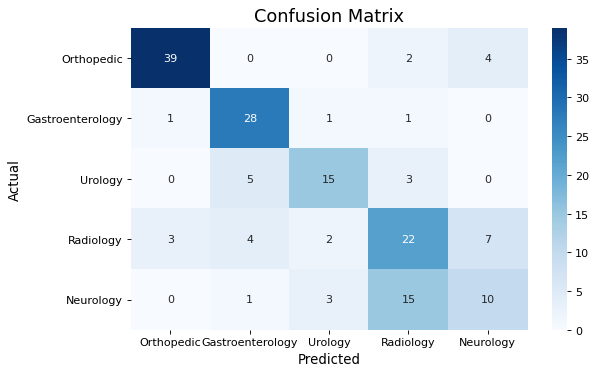

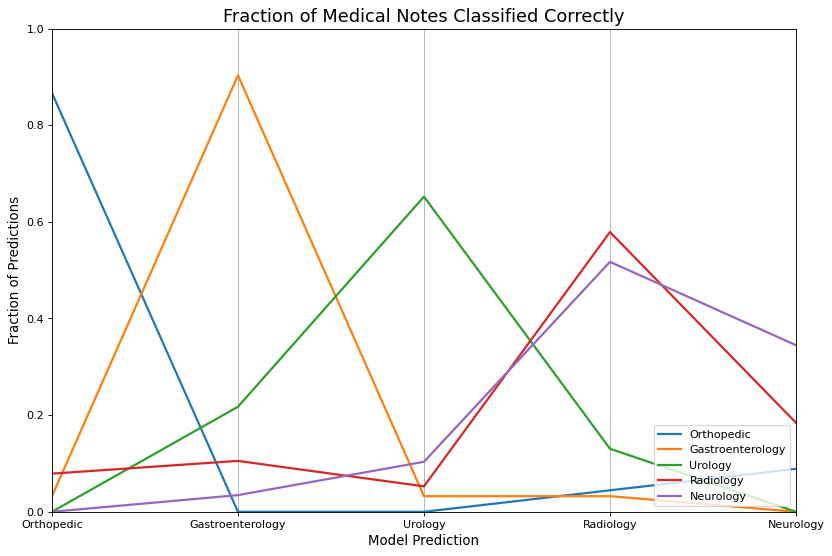

In [21]:
# Plot Multiclass Confusion Matrix
fig, ax = plot_heatmap(confusion, xlabel='Predicted', ylabel='Actual', title='Confusion Matrix',
                       xticklabels=clinical_domain_list, yticklabels=clinical_domain_list,
                       color='Blues', annot=True, fmt='d', dpi=80)
if save:
    plt.savefig("figures/logreg/all-features/confusion.png", transparent=False, bbox_inches="tight")

# Plot Distribution for Each Class
fig, ax = plot_empty(xlabel='Model Prediction', ylabel='Fraction of Predictions',
                     title='Fraction of Medical Notes Classified Correctly',
                     figsize=(12, 8))
for i in range(0, 5):
    ax.plot(clinical_domain_list, confusion_normalized_array[i], label=f'{clinical_domain_list[i]}', lw=2)
ax.set_xlim(0, 4)
ax.set_ylim(0, 1)
plt.legend(loc="lower right")
ax.xaxis.grid(True)
if save:
    plt.savefig("figures/logreg/all-features/fraction-classified-correctly.png", transparent=False, bbox_inches="tight")

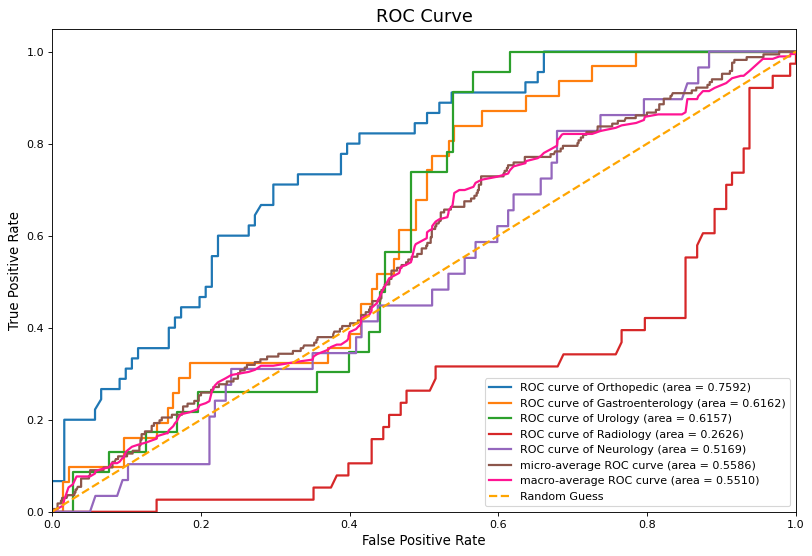

In [22]:
# Compute Multiclass ROC

fpr, tpr, thresholds, roc_auc = compute_multiclass_roc(target_test_bin_array, features_test_vectorized_proba_array)

# Plot Micro-ROC curve for Weighted Test set
fig, ax = plot_empty(xlabel='False Positive Rate', ylabel='True Positive Rate', title='ROC Curve',
                     figsize=(12, 8))
for i in range(5):
    plt.plot(1-fpr[i], 1-tpr[i], label='ROC curve of {0} (area = {1:1.4f})'.format(clinical_domain_list[i], 1-roc_auc[i]), lw=2)
plt.plot(1-fpr["micro"], 1-tpr["micro"], label='micro-average ROC curve (area = {0:0.4f})'.format(1-roc_auc["micro"]), lw=2)
plt.plot(1-fpr["macro"], 1-tpr["macro"], label='macro-average ROC curve (area = {0:0.4f})'.format(1-roc_auc["macro"]), color='deeppink', lw=2)
plt.plot([0, 1], [0, 1], c='orange', lw = 2, ls='--', label= "Random Guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
if save:
    plt.savefig("figures/logreg/all-features/roc.png", transparent=True, bbox_inches="tight")